In [1]:
import sys, os

import numpy as np

import trajectory as T                      # trajectory generation
import optimizer as O                       # stochastic gradient descent optimizer

from maxent import irl

In [2]:
def word_to_state(word):

    verb_positive_words = ['bloom', 'soar', 'soars', 'sparkle', 'thrive', 'illuminates', 'illuminate']
    verb_negative_words = ['complain', 'argue', 'blame', 'grumble', 'snarl']
    verb_inactive_words = ['rest', 'pause', 'hovers', 'hover', 'lazes', 'laze', 'bask']
    verb_active_words = ['smash', 'grab', 'push', 'shout', 'storm']
    adv_time_words = ['suddenly', 'gradually', 'eventually', 'shortly', 'instantly']
    adv_place_words = ['here', 'there', 'everywhere', 'nowhere', 'somewhere']
    adv_interrogative_words = ['curiously', 'wonderingly', 'questioningly', 'doubtfully', 'pensively']
    adv_uncertain_words = ['maybe', 'possibly', 'likely', 'arguably', 'presumably']
    adv_certain_words = ['definitely', 'surely', 'clearly', 'obviously', 'undoubtedly']
    adj_descriptive_words = ['bright', 'calm', 'colorful', 'peaceful', 'radiant']
    adj_quantitative_words = ['little', 'few', 'some', 'many', 'much']
    noun_soft =  ['feather', 'whisper', 'breeze', 'lullaby', 'velvet', 'serenity', 'meadow', 'bubble', 'petal', 'harmony', 'fawn', 'mist', 'silk', 'cushion', 'fluff', 'hush', 'dew', 'sigh', 'cocoon', 'murmur']
    noun_harsh = ['clash', 'fracture', 'gravel', 'jolt', 'quake', 'blaze', 'torrent', 'shatter', 'thorn', 'crunch', 'screech', 'grit', 'splinter', 'snarl', 'flare', 'rupture', 'smog', 'clash', 'blitz', 'jagged']
    first_person_pronouns = ['i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']
    second_person_pronouns = ['you', 'your', 'yours']
    third_person_pronouns = ['he', 'him', 'his', 'she', 'her', 'hers', 'it', 'its', 'they', 'them', 'their', 'theirs']
    prepositions = ['in', 'on', 'under', 'over', 'with', 'without']
    determiners = ['the', 'a', 'an', 'this', 'that', 'these', 'those']
    conjuctions = ['because', 'since', 'as', 'so', 'for', 'and', 'but', 'or']
    ponctuation_neutral = ["."]
    ponctuation_emotional = ["!", "?"]



    word_lower = word.lower()


    if word_lower in verb_positive_words:
        return 'Verb_positive'
    elif word_lower in verb_negative_words:
        return 'Verb_negative'
    elif word_lower in verb_inactive_words:
        return 'Verb_inaction'
    elif word_lower in verb_active_words:
        return 'Verb_action'
    elif word_lower in adv_time_words:
        return 'Adverb_time'
    elif word_lower in adv_place_words:
        return 'Adverb_place'
    elif word_lower in adv_interrogative_words:
        return 'Adverb_interrogative'
    elif word_lower in adj_descriptive_words:
        return 'Adj_descriptive'
    elif word_lower in adj_quantitative_words:
        return 'Adj_quantitative'
    elif word_lower in adv_uncertain_words:
        return 'Adverb_uncertain'
    elif word_lower in adv_certain_words:
        return 'Adverb_certain'
    elif word_lower in conjuctions:
        return 'Conjunction'
    elif word_lower in noun_soft:
        return 'Noun_soft'
    elif word_lower in noun_harsh:
        return 'Noun_harsh'
    elif word_lower in first_person_pronouns:
        return 'P_1st'
    elif word_lower in second_person_pronouns:
        return 'P_2nd'
    elif word_lower in third_person_pronouns:
        return 'P_3rd'
    elif word_lower in prepositions:
        return 'Prep'
    elif word_lower in determiners:
        return 'Det'
    elif word_lower in ponctuation_neutral:
      return 'Ponct_n'
    elif word_lower in ponctuation_emotional:
      return 'Ponct_e'

    else:
        assert False, "Unknown category for the provided word."
        return 'Unknown'




In [3]:
states =  ['Verb_positive',
 'Verb_negative',
 'Verb_action',
 'Verb_inaction',
 'Adverb_time',
 'Adverb_place',
 'Adverb_interrogative',
 'Adj_descriptive',
 'Adj_quantitative',
 'Adverb_certain',
 'Adverb_uncertain',
 'Noun_harsh',
 'Noun_soft',
 'Ponct_n',
 'Ponct_e',
 'P_1st',
 'P_2nd',
 'P_3rd',
 'Prep',
 'Det',
 'Conjunction',
 ]



states_one_hot = np.zeros((len(states), len(states)))

one_hot_encoding_dic = {state: [0] * len(states) for state in states}

state_number_dic = {state: 0  for state in states}


# Set the corresponding index to 1 for each state
for i, state in enumerate(states):
    one_hot_encoding_dic[state][i] = 1
    state_number_dic[state] = i
    states_one_hot[i, i] = 1



In [4]:
from typing import Dict, List, Union
import random

class CFG_1:
    def __init__(self, rules: Dict[str, List[Union[str, List[str]]]], terminals: Dict[str, List[str]]):
        self.rules = rules
        self.terminals = terminals

    def generate(self, symbol: str) -> str:


        production_prev = []

        if symbol in self.rules:
            
            if symbol=="Sentence":
                production = random.choices(self.rules[symbol], weights=(0.1, 0.9), k=1)[0]
            elif symbol=="Simple_1" or symbol=="Simple_2":
                production = random.choices(self.rules[symbol], weights=(0.1, 0.4, 0.5), k=1)[0]
            elif symbol=="Object":
                production = random.choices(self.rules[symbol], weights=(0.1, 0.1, 0.4, 0.4), k=1)[0]
            elif symbol=="Ponctuation":
                production = random.choices(self.rules[symbol], weights=(0.25, 0.75), k=1)[0]
            elif symbol=="Pronoun":
                production = random.choices(self.rules[symbol], weights=(0.7, 0.2, 0.1), k=1)[0]
            elif symbol=="Noun":
                production = random.choices(self.rules[symbol], weights=(0.8, 0.2), k=1)[0]
            elif symbol=="Verb":
                production = random.choices(self.rules[symbol], weights=(0.4, 0.1, 0.1, 0.4), k=1)[0]
            elif symbol=="Adj":
                production = random.choices(self.rules[symbol], weights=(0.8, 0.2), k=1)[0]

            else:
                production = random.choice(self.rules[symbol])
                
            return ' '.join(self.generate(sym) for sym in production).capitalize()
            
        elif symbol in self.terminals:
            return random.choice(self.terminals[symbol])
        else:
            return symbol


In [5]:
class CFG_2:
    def __init__(self, rules: Dict[str, List[Union[str, List[str]]]], terminals: Dict[str, List[str]]):
        self.rules = rules
        self.terminals = terminals

    def generate(self, symbol: str) -> str:


        production_prev = []

        if symbol in self.rules:
            
            if symbol=="Sentence":
                production = random.choices(self.rules[symbol], weights=(0.9, 0.1), k=1)[0]
            elif symbol=="Simple_1" or symbol=="Simple_2":
                production = random.choices(self.rules[symbol], weights=(0.7, 0.3, 0), k=1)[0]
            elif symbol=="VP":
                production = random.choices(self.rules[symbol], weights=(1.0, 0), k=1)[0]
            elif symbol=="Object":
                production = random.choices(self.rules[symbol], weights=(0.4, 0.4, 0.1, 0.1), k=1)[0]
            elif symbol=="Ponctuation":
                production = random.choices(self.rules[symbol], weights=(0.75, 0.25), k=1)[0]
            elif symbol=="Pronoun":
                production = random.choices(self.rules[symbol], weights=(0.1, 0.2, 0.7), k=1)[0]
            elif symbol=="Noun":
                production = random.choices(self.rules[symbol], weights=(0.2, 0.8), k=1)[0]
            elif symbol=="Verb":
                production = random.choices(self.rules[symbol], weights=(0.1, 0.4, 0.4, 0.1), k=1)[0]
            elif symbol=="Adj":
                production = random.choices(self.rules[symbol], weights=(0.2, 0.8), k=1)[0]

            else:
                production = random.choice(self.rules[symbol])
                
            return ' '.join(self.generate(sym) for sym in production).capitalize()
            
        elif symbol in self.terminals:
            return random.choice(self.terminals[symbol])
        else:
            return symbol

In [6]:
cfg_rules = {
    "Sentence": [["Simple_2"], ["Compound"]],
    "Compound": [["Simple_1", "Conjunction", "Simple_2"]],
    "Simple_1": [
        ["Sub", "VP"],
        ["Sub", "VP", "Object"],
        ["Sub", "VP", "Object", "Adverb"]
    ],

    "Simple_2": [
        ["Sub", "VP", "Ponctuation"],
        ["Sub", "VP", "Object", "Ponctuation"],
        ["Sub", "VP", "Object", "Adverb", "Ponctuation"]
    ],
    "Sub": [["Pronoun"], ["Noun"], ["Det", "Noun"], ["Det", "Adj", "Noun"]],
    "VP": [["Verb"], ["Verb", "Adverb"]],
    "Object": [
        ["Det", "Noun"],
        ["Det", "Adj", "Noun"],
        ["Prep", "Det", "Noun"],
        ["Prep", "Det", "Adj", "Noun"]
    ],
    "Noun": [["Noun_soft"], ["Noun_harsh"]],
    "Adj": [["Adj_descriptive"], ["Adj_quantitative"]],
    "Pronoun": [["P_1st"], ["P_2nd"], ["P_3rd"]],
    "Verb": [["Verb_positive"], ["Verb_negative"], ["Verb_action"], ["Verb_inaction"]],
    "Adverb": [["Adverb_time"], ["Adverb_place"], ["Adverb_interrogative"], ["Adverb_certain"], ["Adverb_uncertain"]],
    "Conjunction": [['because'], ['since'], ['as'], ['so'], ['for'], ['and'], ['but'], ['or']],
    "Det": [["the"], ["a"], ["an"], ["this"], ["that"], ["these"], ["those"]],
    "Prep": [["in"], ["on"], ["under"], ["over"], ["with"], ["without"]],
    "Ponctuation": [["Ponct_n"], ["Ponct_e"]]


}

terminal_words = {
    "Verb_positive": ['bloom', 'soar', 'soars', 'sparkle', 'thrive', 'illuminates', 'illuminate'],
    "Verb_negative": ['complain', 'argue', 'blame', 'grumble', 'snarl'],
    "Verb_action": ['smash', 'grab', 'push', 'shout', 'storm'],
    "Verb_inaction": ['rest', 'pause', 'hovers', 'hover', 'lazes', 'laze', 'bask'],
    "Adverb_time": ['suddenly', 'gradually', 'eventually', 'shortly', 'instantly'],
    "Adverb_place": ['here', 'there', 'everywhere', 'nowhere', 'somewhere'],
    "Adverb_interrogative": ['curiously', 'wonderingly', 'questioningly', 'doubtfully', 'pensively'],
    "Adj_descriptive": ['bright', 'calm',  'colorful', 'peaceful', 'radiant'],
    "Adj_quantitative": ['little', 'few', 'some', 'many', 'much'],
    "Adverb_certain": ['definitely', 'surely', 'clearly', 'obviously', 'undoubtedly'],
    "Adverb_uncertain": ['maybe', 'possibly', 'likely', 'arguably', 'presumably'],
    #"Noun_simple": ['car', 'house', 'job', 'money', 'phone', 'discord', 'blight', 'accident', 'damage', 'pain'],
    "Noun_soft": ["Feather", "Whisper", "Breeze", "Lullaby", "Velvet", "Serenity", "Meadow", "Bubble", "Petal", "Harmony",  "Fawn", "Mist", "Silk", "Cushion", "Fluff", "Hush", "Dew", "Sigh", "Cocoon", "Murmur"],
    "Noun_harsh" : [ "Clash", "Fracture", "Gravel", "Jolt", "Quake",  "Blaze", "Torrent", "Shatter", "Thorn", "Crunch",  "Screech", "Grit", "Splinter", "Snarl", "Flare",  "Rupture", "Smog", "Clash", "Blitz", "Jagged"],
    "P_1st": ['i', 'me', 'mine', 'we', 'us', 'our', 'ours'],
    "P_2nd": ['you', 'your', 'yours'],
    "P_3rd": ['he', 'him', 'his', 'she', 'her', 'hers', 'it', 'its', 'they', 'them', 'their', 'theirs'],
    "Ponct_n": ['.'],
    "Ponct_e": ['?', '!']

}

In [7]:
# positive sentences
cfg = CFG_1(cfg_rules, terminal_words)

sentence = cfg.generate("Sentence")
sentence

'Smog bask with a bright sigh maybe so sigh lazes arguably without an many quake shortly ?'

In [8]:
# negative sentences
cfg = CFG_2(cfg_rules, terminal_words)

sentence = cfg.generate("Sentence")
sentence

'His grumble !'

In [9]:
cfg = CFG_1(cfg_rules, terminal_words)


pos_sentences = []


for _ in range(50):

  sentence = cfg.generate("Sentence")
  pos_sentences.append(sentence)

In [10]:
cfg = CFG_2(cfg_rules, terminal_words)


neg_sentences = []


for _ in range(50):

  sentence = cfg.generate("Sentence")
  neg_sentences.append(sentence)

In [11]:
pos_sentences

['An peaceful fluff grumble everywhere under that peaceful harmony because an blaze rest everywhere with this dew somewhere !',
 'We lazes shortly over these dew shortly for dew bloom obviously .',
 'Sigh push likely on these rupture undoubtedly and murmur illuminate that much meadow nowhere .',
 'That cushion sparkle suddenly because the meadow grumble without the fawn pensively !',
 'Meadow snarl a many mist suddenly but fluff sparkle possibly those harmony !',
 'Me sparkle undoubtedly without the cocoon likely because you laze suddenly with those bright hush there ?',
 'Feather pause pensively these many breeze so torrent illuminates somewhere with that fawn obviously !',
 'That cushion pause somewhere a peaceful bubble definitely or those fawn grumble in these dew !',
 'We pause these silk so us smash with the mist ?',
 'The breeze sparkle on an blitz but clash argue possibly this many mist surely ?',
 'An bright lullaby soar suddenly in the bright flare suddenly so ours grumble de

In [12]:
neg_sentences

['Blaze grumble .',
 'That mist storm .',
 'The grit smash an much grit .',
 'That jagged complain a peaceful silk .',
 'Snarl grab .',
 'That some flare argue .',
 'Harmony shout .',
 'This torrent smash !',
 'Those few blitz push ?',
 'They grumble .',
 'A few thorn blame an some cocoon .',
 'An calm cushion shout !',
 'Rupture grumble .',
 'Those little lullaby blame ?',
 'Fracture grab those smog or splinter grab an bright snarl .',
 'You push .',
 'The gravel argue !',
 'An screech thrive this fluff because those little shatter push .',
 'Fracture grab .',
 'This much dew smash !',
 'Theirs grumble .',
 'This bright flare illuminate a quake .',
 'Thorn complain .',
 'That few jolt grab .',
 'Jolt snarl that much splinter .',
 'Theirs snarl !',
 'Theirs argue .',
 'The little blitz blame .',
 'This some blaze grab .',
 'He storm .',
 'Jagged smash .',
 'Flare argue .',
 'Smog grumble .',
 'These breeze smash !',
 'A murmur storm an lullaby .',
 'The some silk laze that torrent .',


In [13]:
for i in range(len(pos_sentences)):
  pos_sentences[i] = pos_sentences[i].split()

for i in range(len(neg_sentences)):
  neg_sentences[i] = neg_sentences[i].split()




In [14]:
pos_sentences

[['An',
  'peaceful',
  'fluff',
  'grumble',
  'everywhere',
  'under',
  'that',
  'peaceful',
  'harmony',
  'because',
  'an',
  'blaze',
  'rest',
  'everywhere',
  'with',
  'this',
  'dew',
  'somewhere',
  '!'],
 ['We',
  'lazes',
  'shortly',
  'over',
  'these',
  'dew',
  'shortly',
  'for',
  'dew',
  'bloom',
  'obviously',
  '.'],
 ['Sigh',
  'push',
  'likely',
  'on',
  'these',
  'rupture',
  'undoubtedly',
  'and',
  'murmur',
  'illuminate',
  'that',
  'much',
  'meadow',
  'nowhere',
  '.'],
 ['That',
  'cushion',
  'sparkle',
  'suddenly',
  'because',
  'the',
  'meadow',
  'grumble',
  'without',
  'the',
  'fawn',
  'pensively',
  '!'],
 ['Meadow',
  'snarl',
  'a',
  'many',
  'mist',
  'suddenly',
  'but',
  'fluff',
  'sparkle',
  'possibly',
  'those',
  'harmony',
  '!'],
 ['Me',
  'sparkle',
  'undoubtedly',
  'without',
  'the',
  'cocoon',
  'likely',
  'because',
  'you',
  'laze',
  'suddenly',
  'with',
  'those',
  'bright',
  'hush',
  'there',
  '

In [15]:
neg_sentences

[['Blaze', 'grumble', '.'],
 ['That', 'mist', 'storm', '.'],
 ['The', 'grit', 'smash', 'an', 'much', 'grit', '.'],
 ['That', 'jagged', 'complain', 'a', 'peaceful', 'silk', '.'],
 ['Snarl', 'grab', '.'],
 ['That', 'some', 'flare', 'argue', '.'],
 ['Harmony', 'shout', '.'],
 ['This', 'torrent', 'smash', '!'],
 ['Those', 'few', 'blitz', 'push', '?'],
 ['They', 'grumble', '.'],
 ['A', 'few', 'thorn', 'blame', 'an', 'some', 'cocoon', '.'],
 ['An', 'calm', 'cushion', 'shout', '!'],
 ['Rupture', 'grumble', '.'],
 ['Those', 'little', 'lullaby', 'blame', '?'],
 ['Fracture',
  'grab',
  'those',
  'smog',
  'or',
  'splinter',
  'grab',
  'an',
  'bright',
  'snarl',
  '.'],
 ['You', 'push', '.'],
 ['The', 'gravel', 'argue', '!'],
 ['An',
  'screech',
  'thrive',
  'this',
  'fluff',
  'because',
  'those',
  'little',
  'shatter',
  'push',
  '.'],
 ['Fracture', 'grab', '.'],
 ['This', 'much', 'dew', 'smash', '!'],
 ['Theirs', 'grumble', '.'],
 ['This', 'bright', 'flare', 'illuminate', 'a', 'qu

In [16]:
D_pos= []

for i, sentence in enumerate(pos_sentences):

  episode_pos = []

  for j, word in enumerate(sentence[:-1]):


    s = np.argmax(one_hot_encoding_dic[word_to_state(word)] )
    a = np.argmax(one_hot_encoding_dic[word_to_state(sentence[j+1])] )
    episode_pos.append((s, a, a))


  D_pos.append(T.Trajectory(episode_pos))



D_neg= []

for i, sentence in enumerate(neg_sentences):

  episode_neg = []

  for j, word in enumerate(sentence[:-1]):

    s = np.argmax(one_hot_encoding_dic[word_to_state(word)] )
    a = np.argmax(one_hot_encoding_dic[word_to_state(sentence[j+1])] )
    episode_neg.append((s, a, a))

  D_neg.append(T.Trajectory(episode_neg))

In [17]:
D_pos

[Trajectory([(19, 7, 7), (7, 12, 12), (12, 1, 1), (1, 5, 5), (5, 18, 18), (18, 19, 19), (19, 7, 7), (7, 12, 12), (12, 20, 20), (20, 19, 19), (19, 11, 11), (11, 3, 3), (3, 5, 5), (5, 18, 18), (18, 19, 19), (19, 12, 12), (12, 5, 5), (5, 14, 14)]),
 Trajectory([(15, 3, 3), (3, 4, 4), (4, 18, 18), (18, 19, 19), (19, 12, 12), (12, 4, 4), (4, 20, 20), (20, 12, 12), (12, 0, 0), (0, 9, 9), (9, 13, 13)]),
 Trajectory([(12, 2, 2), (2, 10, 10), (10, 18, 18), (18, 19, 19), (19, 11, 11), (11, 9, 9), (9, 20, 20), (20, 12, 12), (12, 0, 0), (0, 19, 19), (19, 8, 8), (8, 12, 12), (12, 5, 5), (5, 13, 13)]),
 Trajectory([(19, 12, 12), (12, 0, 0), (0, 4, 4), (4, 20, 20), (20, 19, 19), (19, 12, 12), (12, 1, 1), (1, 18, 18), (18, 19, 19), (19, 12, 12), (12, 6, 6), (6, 14, 14)]),
 Trajectory([(12, 1, 1), (1, 19, 19), (19, 8, 8), (8, 12, 12), (12, 4, 4), (4, 20, 20), (20, 12, 12), (12, 0, 0), (0, 10, 10), (10, 19, 19), (19, 12, 12), (12, 14, 14)]),
 Trajectory([(15, 0, 0), (0, 9, 9), (9, 18, 18), (18, 19, 19),

In [18]:
D_neg

[Trajectory([(11, 1, 1), (1, 13, 13)]),
 Trajectory([(19, 12, 12), (12, 2, 2), (2, 13, 13)]),
 Trajectory([(19, 11, 11), (11, 2, 2), (2, 19, 19), (19, 8, 8), (8, 11, 11), (11, 13, 13)]),
 Trajectory([(19, 11, 11), (11, 1, 1), (1, 19, 19), (19, 7, 7), (7, 12, 12), (12, 13, 13)]),
 Trajectory([(1, 2, 2), (2, 13, 13)]),
 Trajectory([(19, 8, 8), (8, 11, 11), (11, 1, 1), (1, 13, 13)]),
 Trajectory([(12, 2, 2), (2, 13, 13)]),
 Trajectory([(19, 11, 11), (11, 2, 2), (2, 14, 14)]),
 Trajectory([(19, 8, 8), (8, 11, 11), (11, 2, 2), (2, 14, 14)]),
 Trajectory([(17, 1, 1), (1, 13, 13)]),
 Trajectory([(19, 8, 8), (8, 11, 11), (11, 1, 1), (1, 19, 19), (19, 8, 8), (8, 12, 12), (12, 13, 13)]),
 Trajectory([(19, 7, 7), (7, 12, 12), (12, 2, 2), (2, 14, 14)]),
 Trajectory([(11, 1, 1), (1, 13, 13)]),
 Trajectory([(19, 8, 8), (8, 12, 12), (12, 1, 1), (1, 14, 14)]),
 Trajectory([(11, 2, 2), (2, 19, 19), (19, 11, 11), (11, 20, 20), (20, 11, 11), (11, 2, 2), (2, 19, 19), (19, 7, 7), (7, 1, 1), (1, 13, 13)]),


In [19]:
states_one_hot

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.,

In [20]:
terminal_pos = []

for traj in D_pos:
  terminal_pos.append(traj._t[-1][-1])

terminal_pos = list(set(terminal_pos))

In [21]:
terminal_neg = []

for traj in D_neg:
  terminal_neg.append(traj._t[-1][-1])

terminal_neg = list(set(terminal_neg))

In [22]:
terminal_pos

[13, 14]

In [23]:
terminal_neg

[13, 14]

In [24]:
state_number_dic

{'Verb_positive': 0,
 'Verb_negative': 1,
 'Verb_action': 2,
 'Verb_inaction': 3,
 'Adverb_time': 4,
 'Adverb_place': 5,
 'Adverb_interrogative': 6,
 'Adj_descriptive': 7,
 'Adj_quantitative': 8,
 'Adverb_certain': 9,
 'Adverb_uncertain': 10,
 'Noun_harsh': 11,
 'Noun_soft': 12,
 'Ponct_n': 13,
 'Ponct_e': 14,
 'P_1st': 15,
 'P_2nd': 16,
 'P_3rd': 17,
 'Prep': 18,
 'Det': 19,
 'Conjunction': 20}

In [25]:
states

['Verb_positive',
 'Verb_negative',
 'Verb_action',
 'Verb_inaction',
 'Adverb_time',
 'Adverb_place',
 'Adverb_interrogative',
 'Adj_descriptive',
 'Adj_quantitative',
 'Adverb_certain',
 'Adverb_uncertain',
 'Noun_harsh',
 'Noun_soft',
 'Ponct_n',
 'Ponct_e',
 'P_1st',
 'P_2nd',
 'P_3rd',
 'Prep',
 'Det',
 'Conjunction']

In [26]:
num_state = states_one_hot.shape[0]

transition = np.zeros((len(states), len(states), len(states)))

for i in range(num_state):
    transition[:, i, i] = 1

transition.shape

(21, 21, 21)

In [27]:
init_pos = O.Constant(1.0)
optim_pos = O.ExpSga(lr=O.linear_decay(lr0=0.1))


init_neg = O.Constant(1.0)
optim_neg = O.ExpSga(lr=O.linear_decay(lr0=0.1))


reward_maxent_pos = irl(transition, states_one_hot, terminal_pos, D_pos, optim_pos, init_pos)
reward_maxent_neg = irl(transition, states_one_hot, terminal_neg, D_neg, optim_neg, init_neg)

In [28]:
reward_maxent_pos

array([1.23170347, 0.86075257, 0.79629683, 1.14700684, 0.91767646,
       0.92941515, 0.91767646, 1.35047126, 0.89455365, 0.97755452,
       0.91767646, 1.04039209, 2.3876889 , 0.87190221, 1.14700684,
       0.81731975, 0.74572947, 0.74572947, 1.62052324, 2.20312262,
       1.30519428])

In [29]:
reward_maxent_neg

array([0.79481255, 0.98087493, 1.00239338, 0.78591657, 0.75974751,
       0.75974751, 0.75974751, 0.8037958 , 0.8985227 , 0.75974751,
       0.75974751, 1.00239338, 0.87885586, 1.16350668, 0.85955273,
       0.75974751, 0.75974751, 0.75974751, 0.75974751, 0.88864364,
       0.79481255])

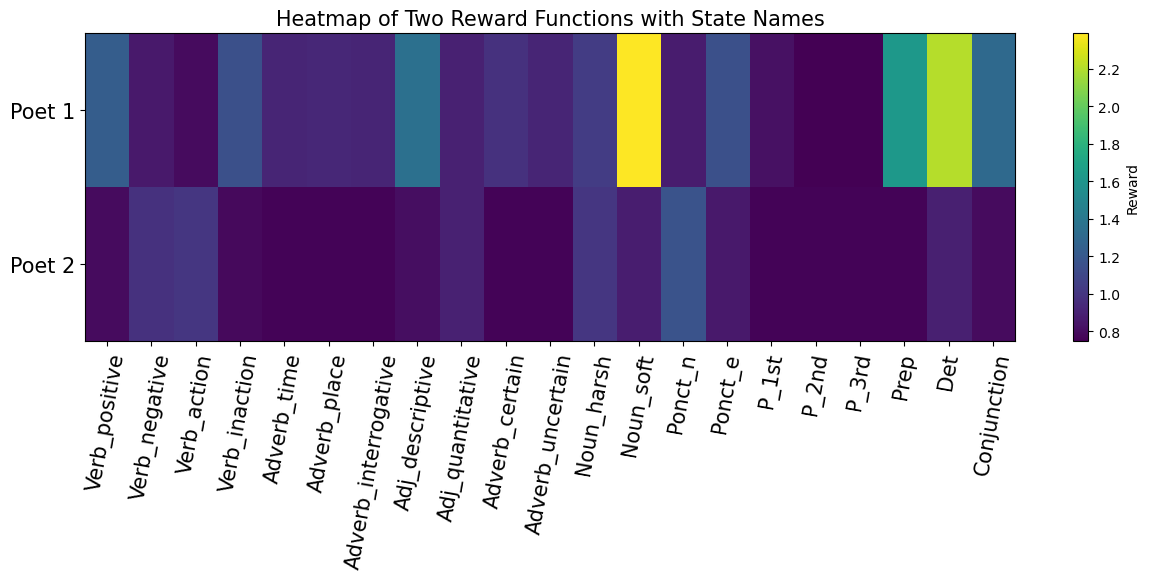

In [30]:
import matplotlib.pyplot as plt


size_text = 15


# Example list of state names (replace with your actual list of state names)
state_names = states

rewards = np.array([reward_maxent_pos, reward_maxent_neg])


# Creating the heatmap
plt.figure(figsize=(15, 4))  # Adjusted figure size for better readability
plt.imshow(rewards, cmap='viridis', aspect='auto')
plt.colorbar(label='Reward')

# Adding labels and title
plt.title('Heatmap of Two Reward Functions with State Names', fontsize = size_text)
# plt.xlabel('States', fontsize = size_text)
# plt.ylabel('Reward Function', fontsize = size_text)
plt.yticks([0, 1], ['Poet 1', 'Poet 2'], fontsize = size_text)
plt.xticks(np.arange(len(states)), labels=state_names, rotation=80, fontsize = size_text)  # Rotate for readability

#plt.tight_layout()
plt.savefig("enriched_heatmap.png", format="png", bbox_inches='tight')

plt.show()


# Non-enriched CFG 

In [31]:
def word_to_state_ne(word):

    verb = ['bloom', 'soar', 'soars', 'sparkle', 'thrive', 'illuminates', 'illuminate', 
             'complain', 'argue', 'blame', 'grumble', 'snarl', 'smash', 'grab', 'push', 'shout', 'storm',
            'rest', 'pause', 'hovers', 'hover', 'lazes', 'laze', 'bask']
    adverb = ['suddenly', 'gradually', 'eventually', 'shortly', 'instantly',
              'here', 'there', 'everywhere', 'nowhere', 'somewhere',
              'curiously', 'wonderingly', 'questioningly', 'doubtfully', 'pensively',
              'definitely', 'surely', 'clearly', 'obviously', 'undoubtedly', 'maybe', 'possibly', 'likely', 'arguably', 'presumably']
    adj = ['bright', 'calm',  'colorful', 'peaceful', 'radiant', 'little', 'few', 'some', 'many', 'much']
    noun = ['car', 'house', 'job', 'money', 'phone', 'discord', 'blight', 'accident', 'damage', 'pain',
            "feather", "whisper", "breeze", "lullaby", "velvet", "serenity", "meadow", "bubble", "petal",
            "harmony",  "fawn", "mist", "silk", "cushion", "fluff", "hush", "dew", "sigh", "cocoon", "murmur",
            "clash", "fracture", "gravel", "jolt", "quake",  "blaze", "torrent", "shatter", "thorn", "crunch",
            "screech", "grit", "splinter", "snarl", "flare",  "rupture", "smog", "clash", "blitz", "jagged"]
    pronoun = ['i', 'me', 'mine', 'we', 'us', 'our', 'ours', 'you', 'your', 'yours', 
               'he', 'him', 'his', 'she', 'her', 'hers', 'it', 'its', 'they', 'them', 'their', 'theirs']
    ponctuation = ['.', '?', '!']
    prepositions = ['in', 'on', 'under', 'over', 'with', 'without']
    determiners = ['the', 'a', 'an', 'this', 'that', 'these', 'those']
    conjuctions = ['because', 'since', 'as', 'so', 'for', 'and', 'but', 'or']


    word_lower = word.lower()


    if word_lower in verb:
        return 'Verb'
    elif word_lower in adverb:
        return 'Adverb'
    elif word_lower in adj:
        return 'Adj'
    elif word_lower in conjuctions:
        return 'Conjunction'
    elif word_lower in noun:
        return 'Noun'
    elif word_lower in pronoun:
        return 'Pronoun'
    elif word_lower in prepositions:
        return 'Prep'
    elif word_lower in determiners:
        return 'Det'
    elif word_lower in ponctuation:
      return 'Ponctuation'

    else:
        assert False, "Unknown category for the provided word."
        return 'Unknown'




In [32]:
states_ne =  ['Verb',
 'Adverb',
 'Adj',
 'Noun',
 'Ponctuation',
 'Pronoun',
 'Prep',
 'Det',
 'Conjunction',
 ]

states_one_hot_ne = np.zeros((len(states_ne), len(states_ne)))

one_hot_encoding_dic_ne = {state: [0] * len(states_ne) for state in states_ne}

state_number_dic_ne = {state: 0  for state in states_ne}


# Set the corresponding index to 1 for each state
for i, state in enumerate(states_ne):
    one_hot_encoding_dic_ne[state][i] = 1
    state_number_dic_ne[state] = i
    states_one_hot_ne[i, i] = 1

In [33]:
one_hot_encoding_dic_ne

{'Verb': [1, 0, 0, 0, 0, 0, 0, 0, 0],
 'Adverb': [0, 1, 0, 0, 0, 0, 0, 0, 0],
 'Adj': [0, 0, 1, 0, 0, 0, 0, 0, 0],
 'Noun': [0, 0, 0, 1, 0, 0, 0, 0, 0],
 'Ponctuation': [0, 0, 0, 0, 1, 0, 0, 0, 0],
 'Pronoun': [0, 0, 0, 0, 0, 1, 0, 0, 0],
 'Prep': [0, 0, 0, 0, 0, 0, 1, 0, 0],
 'Det': [0, 0, 0, 0, 0, 0, 0, 1, 0],
 'Conjunction': [0, 0, 0, 0, 0, 0, 0, 0, 1]}

In [34]:
class CFG_1_non_enriched:
    def __init__(self, rules: Dict[str, List[Union[str, List[str]]]], terminals: Dict[str, List[str]]):
        self.rules = rules
        self.terminals = terminals

    def generate(self, symbol: str) -> str:

        production_prev = []

        if symbol in self.rules:
            
            if symbol=="Sentence":
                production = random.choices(self.rules[symbol], weights=(0.1, 0.9), k=1)[0]
            elif symbol=="Simple_1" or symbol=="Simple_2":
                production = random.choices(self.rules[symbol], weights=(0.1, 0.4, 0.5), k=1)[0]
            elif symbol=="Object":
                production = random.choices(self.rules[symbol], weights=(0.1, 0.1, 0.4, 0.4), k=1)[0]

            else:
                production = random.choice(self.rules[symbol])
                
            return ' '.join(self.generate(sym) for sym in production).capitalize()
            
        elif symbol in self.terminals:
            return random.choice(self.terminals[symbol])
        else:
            return symbol

In [35]:
class CFG_2_non_enriched:
    def __init__(self, rules: Dict[str, List[Union[str, List[str]]]], terminals: Dict[str, List[str]]):
        self.rules = rules
        self.terminals = terminals

    def generate(self, symbol: str) -> str:

        production_prev = []

        if symbol in self.rules:
            
            if symbol=="Sentence":
                production = random.choices(self.rules[symbol], weights=(0.9, 0.1), k=1)[0]
            elif symbol=="Simple_1" or symbol=="Simple_2":
                production = random.choices(self.rules[symbol], weights=(0.5, 0.4, 0.1), k=1)[0]
            elif symbol=="Object":
                production = random.choices(self.rules[symbol], weights=(0.4, 0.4, 0.1, 0.1), k=1)[0]

            else:
                production = random.choice(self.rules[symbol])
                
            return ' '.join(self.generate(sym) for sym in production).capitalize()
            
        elif symbol in self.terminals:
            return random.choice(self.terminals[symbol])
        else:
            return symbol

In [36]:
class CFG_non_enriched_no_weights:
    def __init__(self, rules: Dict[str, List[Union[str, List[str]]]], terminals: Dict[str, List[str]]):
        self.rules = rules
        self.terminals = terminals

    def generate(self, symbol: str) -> str:

        production_prev = []

        if symbol in self.rules:
            
            production = random.choice(self.rules[symbol])
            return ' '.join(self.generate(sym) for sym in production).capitalize()
            
        elif symbol in self.terminals:
            return random.choice(self.terminals[symbol])
        else:
            return symbol

In [37]:
cfg_rules_ne = {
    "Sentence": [["Simple_2"], ["Compound"]],
    "Compound": [["Simple_1", "Conjunction", "Simple_2"]],
    "Simple_1": [
        ["Sub", "VP"],
        ["Sub", "VP", "Object"],
        ["Sub", "VP", "Object", "Adverb"]
    ],

    "Simple_2": [
        ["Sub", "VP", "Ponctuation"],
        ["Sub", "VP", "Object", "Ponctuation"],
        ["Sub", "VP", "Object", "Adverb", "Ponctuation"]
    ],
    "Sub": [["Pronoun"], ["Noun"], ["Det", "Noun"], ["Det", "Adj", "Noun"]],
    "VP": [["Verb"], ["Verb", "Adverb"]],
    "Object": [
        ["Det", "Noun"],
        ["Det", "Adj", "Noun"],
        ["Prep", "Det", "Noun"],
        ["Prep", "Det", "Adj", "Noun"]
    ],
    "Conjunction": [['because'], ['since'], ['as'], ['so'], ['for'], ['and'], ['but'], ['or']],
    "Det": [["the"], ["a"], ["an"], ["this"], ["that"], ["these"], ["those"]],
    "Prep": [["in"], ["on"], ["under"], ["over"], ["with"], ["without"]],
}

terminal_words_ne = {
    "Verb": ['bloom', 'soar', 'soars', 'sparkle', 'thrive', 'illuminates', 'illuminate', 
             'complain', 'argue', 'blame', 'grumble', 'snarl', 'smash', 'grab', 'push', 'shout', 'storm',
            'rest', 'pause', 'hovers', 'hover', 'lazes', 'laze', 'bask'],
    "Adverb": ['suddenly', 'gradually', 'eventually', 'shortly', 'instantly',
              'here', 'there', 'everywhere', 'nowhere', 'somewhere',
              'curiously', 'wonderingly', 'questioningly', 'doubtfully', 'pensively',
              'definitely', 'surely', 'clearly', 'obviously', 'undoubtedly', 'maybe', 'possibly', 'likely', 'arguably', 'presumably'],
    "Adj": ['bright', 'calm',  'colorful', 'peaceful', 'radiant', 'little', 'few', 'some', 'many', 'much'],
    "Noun": ['car', 'house', 'job', 'money', 'phone', 'discord', 'blight', 'accident', 'damage', 'pain',
            "Feather", "Whisper", "Breeze", "Lullaby", "Velvet", "Serenity", "Meadow", "Bubble", "Petal",
            "Harmony",  "Fawn", "Mist", "Silk", "Cushion", "Fluff", "Hush", "Dew", "Sigh", "Cocoon", "Murmur",
            "Clash", "Fracture", "Gravel", "Jolt", "Quake",  "Blaze", "Torrent", "Shatter", "Thorn", "Crunch",
            "Screech", "Grit", "Splinter", "Snarl", "Flare",  "Rupture", "Smog", "Clash", "Blitz", "Jagged"],
    "Pronoun": ['i', 'me', 'mine', 'we', 'us', 'our', 'ours', 'you', 'your', 'yours', 
               'he', 'him', 'his', 'she', 'her', 'hers', 'it', 'its', 'they', 'them', 'their', 'theirs'],
    "Ponctuation": ['.', '?', '!'],
}

In [38]:
# positive sentences
cfg_1_ne = CFG_1_non_enriched(cfg_rules_ne, terminal_words_ne)

sentence = cfg_1_ne.generate("Sentence")
sentence

'We complain over that fluff here because cocoon sparkle under those radiant harmony !'

In [39]:
pos_sentences_ne = []

for _ in range(50):
  sentence = cfg_1_ne.generate("Sentence")
  pos_sentences_ne.append(sentence)

In [40]:
# negative sentences
cfg_2_ne = CFG_2_non_enriched(cfg_rules_ne, terminal_words_ne)

sentence = cfg_2_ne.generate("Sentence")
sentence

'Blitz soar everywhere this many bubble and these few velvet rest these peaceful money ?'

In [41]:
neg_sentences_ne = []

for _ in range(50):
  sentence = cfg_2_ne.generate("Sentence")
  neg_sentences_ne.append(sentence)

In [42]:
# mixed sentences (no weights)
cfg_ne = CFG_non_enriched_no_weights(cfg_rules_ne, terminal_words_ne)

sentence = cfg_ne.generate("Sentence")
sentence

'Flare bloom maybe for these shatter bloom shortly on an colorful clash curiously !'

In [43]:
mixed_sentences_ne = []

for _ in range(50):
  sentence = cfg_ne.generate("Sentence")
  mixed_sentences_ne.append(sentence)

In [44]:
for i in range(len(pos_sentences_ne)):
  pos_sentences_ne[i] = pos_sentences_ne[i].split()

for i in range(len(neg_sentences_ne)):
  neg_sentences_ne[i] = neg_sentences_ne[i].split()

for i in range(len(mixed_sentences_ne)):
  mixed_sentences_ne[i] = mixed_sentences_ne[i].split()

In [45]:
pos_sentences_ne

[['These',
  'little',
  'bubble',
  'blame',
  'nowhere',
  'without',
  'a',
  'peaceful',
  'rupture',
  'doubtfully',
  'and',
  'her',
  'sparkle',
  'gradually',
  'over',
  'the',
  'fracture',
  'instantly',
  '!'],
 ['Lullaby',
  'rest',
  'because',
  'the',
  'much',
  'serenity',
  'soar',
  'under',
  'these',
  'many',
  'meadow',
  'instantly',
  '.'],
 ['Those',
  'discord',
  'illuminates',
  'undoubtedly',
  'in',
  'an',
  'peaceful',
  'whisper',
  'definitely',
  'because',
  'this',
  'car',
  'smash',
  'there',
  'without',
  'these',
  'petal',
  'instantly',
  '?'],
 ['The',
  'serenity',
  'grab',
  'in',
  'that',
  'many',
  'whisper',
  'as',
  'screech',
  'lazes',
  'presumably',
  'with',
  'this',
  'some',
  'harmony',
  '?'],
 ['Those',
  'bright',
  'grit',
  'argue',
  'presumably',
  'under',
  'a',
  'harmony',
  'everywhere',
  'as',
  'they',
  'complain',
  'suddenly',
  'those',
  'calm',
  'jagged',
  'presumably',
  '.'],
 ['This',
  'much'

In [46]:
D_pos_ne= []

for i, sentence in enumerate(pos_sentences_ne):

  episode_pos = []

  for j, word in enumerate(sentence[:-1]):
    s = np.argmax(one_hot_encoding_dic_ne[word_to_state_ne(word)] )
    a = np.argmax(one_hot_encoding_dic_ne[word_to_state_ne(sentence[j+1])] )
    episode_pos.append((s, a, a))
    
  D_pos_ne.append(T.Trajectory(episode_pos))


D_neg_ne= []

for i, sentence in enumerate(neg_sentences_ne):

  episode_neg = []

  for j, word in enumerate(sentence[:-1]):
    s = np.argmax(one_hot_encoding_dic_ne[word_to_state_ne(word)] )
    a = np.argmax(one_hot_encoding_dic_ne[word_to_state_ne(sentence[j+1])] )
    episode_neg.append((s, a, a))

  D_neg_ne.append(T.Trajectory(episode_neg))


D_ne= []

for i, sentence in enumerate(mixed_sentences_ne):

  episode_mixed = []

  for j, word in enumerate(sentence[:-1]):

    s = np.argmax(one_hot_encoding_dic_ne[word_to_state_ne(word)] )
    a = np.argmax(one_hot_encoding_dic_ne[word_to_state_ne(sentence[j+1])] )
    episode_mixed.append((s, a, a))

  D_ne.append(T.Trajectory(episode_mixed))

In [47]:
terminal_pos_ne = []

for traj in D_pos_ne:
  terminal_pos_ne.append(traj._t[-1][-1])

terminal_pos_ne = list(set(terminal_pos_ne))

In [48]:
terminal_neg_ne = []

for traj in D_neg_ne:
  terminal_neg_ne.append(traj._t[-1][-1])

terminal_neg_ne = list(set(terminal_neg_ne))

In [49]:
terminal_ne = []

for traj in D_ne:
  terminal_ne.append(traj._t[-1][-1])

terminal_ne = list(set(terminal_ne))

In [50]:
terminal_pos_ne

[4]

In [51]:
terminal_neg_ne

[4]

In [52]:
terminal_ne

[4]

In [53]:
num_state_ne = states_one_hot_ne.shape[0]

transition_ne = np.zeros((len(states_ne), len(states_ne), len(states_ne)))

for i in range(num_state_ne):
    transition_ne[:, i, i] = 1

transition_ne.shape

(9, 9, 9)

In [54]:
init_pos_ne = O.Constant(1.0)
optim_pos_ne = O.ExpSga(lr=O.linear_decay(lr0=0.1))

init_neg_ne = O.Constant(1.0)
optim_neg_ne = O.ExpSga(lr=O.linear_decay(lr0=0.1))

init_ne = O.Constant(1.0)
optim_ne = O.ExpSga(lr=O.linear_decay(lr0=0.1))

reward_maxent_pos_ne = irl(transition_ne, states_one_hot_ne, terminal_pos_ne, D_pos_ne, optim_pos_ne, init_pos_ne)
reward_maxent_neg_ne = irl(transition_ne, states_one_hot_ne, terminal_neg_ne, D_neg_ne, optim_neg_ne, init_neg_ne)
reward_maxent_ne = irl(transition_ne, states_one_hot_ne, terminal_ne, D_ne, optim_ne, init_ne)

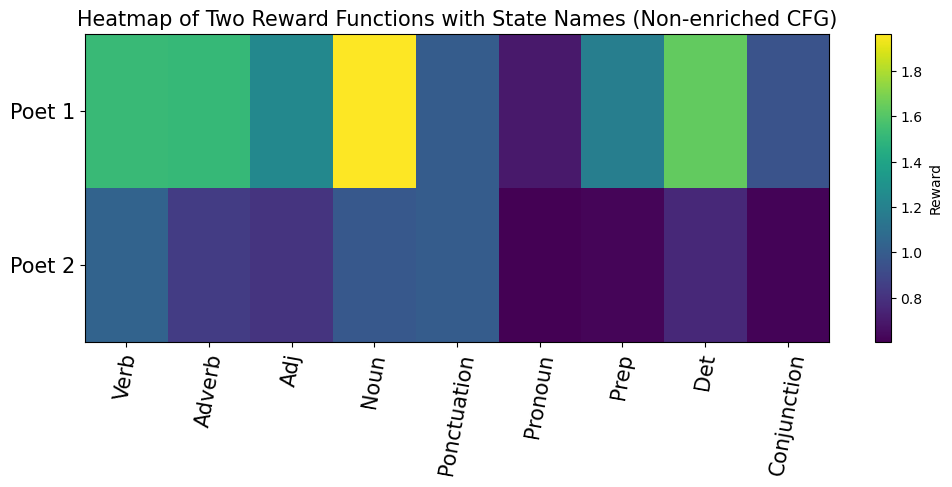

In [57]:
size_text = 15


# Example list of state names (replace with your actual list of state names)
state_names_ne = states_ne

rewards = np.array([reward_maxent_pos_ne, reward_maxent_neg_ne])


# Creating the heatmap
plt.figure(figsize=(12, 4))  # Adjusted figure size for better readability
plt.imshow(rewards, cmap='viridis', aspect='auto')
plt.colorbar(label='Reward')

# Adding labels and title
plt.title('Heatmap of Two Reward Functions with State Names (Non-enriched CFG)', fontsize = size_text)
# plt.xlabel('States', fontsize = size_text)
# plt.ylabel('Reward Function', fontsize = size_text)
plt.yticks([0,1], ['Poet 1', 'Poet 2'], fontsize = size_text)
plt.xticks(np.arange(len(states_ne)), labels=state_names_ne, rotation=80, fontsize = size_text)  # Rotate for readability

plt.savefig('non_enriched_heatmat.png', format='png', bbox_inches='tight')

plt.show()